In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from scipy import stats
import matplotlib.pyplot as plt


mag_v_sun = -26.72              #Sun's V magnitude of Gaia   Jordi et al. 2010

## Definition functions

### Model Magnitud

In [2]:
def model_magnitud(theta, data):
    mag_v_sun = -26.72

    phase_angle = data['solar_phase_angle']
    range_sat = data['range_sat']
    cross_section = theta['cross_section']
    albedo = theta['albedo'] 
    mix_coef = theta['mix_coef']

   # Change degrees to radian
    degtorad = lambda x : x*np.pi/180.

   # Definition coefficients of equation
    coe_1 = 2/(3*np.pi)
    coe_2 = 1/(4*np.pi)

    phase_angle_rad = degtorad(phase_angle)	

   
    part1 = (coe_1 *((np.pi - phase_angle_rad)*np.cos(phase_angle_rad) - np.sin(phase_angle_rad))) - coe_2
   
    model_value = mag_v_sun - 2.5 * np.log10(cross_section * albedo * (mix_coef * part1) + coe_2) + 5*np.log10(range_sat)
    
    frame = {'model_value': model_value}
    model_value_est = pd.DataFrame(frame)


    return model_value_est

### Sum Square

In [3]:
def sum_squares(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_observation'] + data['e_mag']) + model_value
    residual = (rest ** 2).sum(axis=0)/(rest.shape[0] - theta.shape[1])
    estimator = [residual, rest]
    
    return estimator

### Markov Chains

In [4]:
def markov_chains(init_point, std_point, size_chain):
    chain = np.random.normal(init_point, std_point, size_chain).round(3)
    
    return chain

### Beta distribution

In [ ]:
def beta(x):
    sample_beta = stats.beta(1,1)
    r = sample_beta.rvs(x)
    return r

### Read Data

#### PC

In [5]:
path = '/home/kero/Documents/PhD/Re-analyse/result_analyse.csv'

data_sat = pd.read_csv(path)

data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['obs_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_observation'] = data_sat['mag_observation']
data_in['e_mag'] = data_sat['mag_observation_e']
n = data_in.shape[0]

#### Laptop

In [ ]:
path = '/home/kero/Documents/PhD/re-analyse/test.csv'

data_sat = pd.read_csv(path)
data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['SunPhaseAng']
data_in['range_sat'] = data_sat['ObsTrailLength']
data_in['mag_observation'] = data_sat['ObsMag']
data_in['e_mag'] = data_sat['e_ObsMag']

### Markov chain Monte Carlo

In [6]:
p_value = 0.815
num_simulations = 5000

good_p_value = []
mixing_coeffient_est = []
albedo_est = []
cross_section_est = []

mix_init_point = 0.75
mix_std_point = 0.12
cross_init_point = 0.8
cross_std_point = 0.35
albedo_init_point = 0.55
albedo_std_point = 0.2

size_chain_in = data_in.shape[0]

for i in range(num_simulations):
    mix_coef_markov = markov_chains(mix_init_point, mix_std_point, size_chain_in)
    albedo_markov = markov_chains(albedo_init_point, albedo_std_point, size_chain_in)
    cross_section_markov = markov_chains(cross_init_point, cross_std_point, size_chain_in)

    mix_coef = np.random.choice(mix_coef_markov)
    albedo = np.random.choice(albedo_markov)
    cross_section = np.random.choice(cross_section_markov)

    parameters = pd.DataFrame(data={'mix_coef': mix_coef,
                            'albedo': albedo,
                            'cross_section' : cross_section},
                            index=range(data_in.shape[0]))

    model_value = model_magnitud(parameters, data_in)

    estimador = sum_squares(parameters, data_in)

    if (estimador[0] < p_value) and (albedo > 0.) and (cross_section > 0.5):
        p_value = estimador[0]
        good_p_value.append(p_value)
        mixing_coeffient_est.append(mix_coef)
        albedo_est.append(albedo)
        cross_section_est.append(cross_section)

        mix_init_point = mix_coef
        albedo_init_point = albedo
        cross_init_point = cross_section

        print(estimador[0])
        print('mixing_coeffient= ', mix_coef)
        print('albedo= ', albedo)
        print('cross_section= ', cross_section)
        # print('model_value= ', model_value[1])
        # print('mag_obs= ', data_in.mag_observation[1])
        print('============================================')


result_fit = pd.DataFrame(index=range(len(mixing_coeffient_est)), data={
                                                    'p_value': good_p_value,
                                                    'mixing_coeffient_est': mixing_coeffient_est,
                                                    'albedo_est': albedo_est,
                                                    'cross_section_est' : cross_section_est})



0.8114534663252793
mixing_coeffient=  0.68
albedo=  0.039
cross_section=  0.754
0.811130775342051
mixing_coeffient=  0.609
albedo=  0.033
cross_section=  1.248


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

0.8111300605126516
mixing_coeffient=  0.598
albedo=  0.037
cross_section=  1.138
0.8111291700840068
mixing_coeffient=  0.688
albedo=  0.056
cross_section=  0.66


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

0.8111291674796605
mixing_coeffient=  0.637
albedo=  0.062
cross_section=  0.646


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

In [13]:
data_plot = pd.concat([data_in, 
                        model_value.model_value*(-1)], axis=1, join='inner')
data_plot['mag_plus_error'] = data_plot.mag_observation + data_plot.e_mag
e_mag_est = data_in.mag_observation + model_value.model_value
data_plot['e_mag_model'] = e_mag_est


In [14]:
data_plot 

,solar_phase_angle,range_sat,mag_observation,e_mag,model_value,mag_plus_error,e_mag_model
0,32.245458,278.637971,15.763537,1.174024,12.469473,16.937561,3.294065
1,37.593041,311.628229,11.136103,0.082663,12.099877,11.218766,-0.963774
2,29.029426,353.667454,10.923933,0.086001,12.020441,11.009935,-1.096507
3,23.473494,920.908169,10.256544,0.056645,10.049323,10.313189,0.207220
4,37.262504,1243.445283,9.272100,0.094529,9.103231,9.366629,0.168869
...,...,...,...,...,...,...,...
139,15.112193,2021.599779,5.544144,0.037216,8.477728,5.581360,-2.933584
140,18.881421,1922.613217,5.492766,0.043305,8.529063,5.536070,-3.036297
141,12.155282,1732.383001,5.474251,0.042369,8.854393,5.516620,-3.380141
142,22.562450,1834.766768,5.345930,0.032044,8.568712,5.377974,-3.222782


In [ ]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [ ]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_plus_error", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [ ]:
data_plot.describe()

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=data_plot, x="e_mag", kde=True)

In [ ]:
result_fit.describe()

In [ ]:
result_fit

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=result_fit, x="mixing_coeffient_est", kde=True)

In [ ]:
sns.lineplot(data=result_fit, x="mixing_coeffient_est", y="p_value", markers=True, dashes=False)

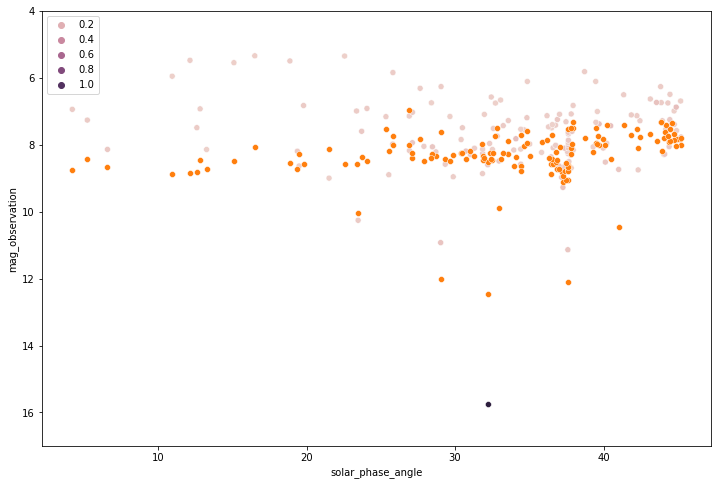

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')
ax.set_ylim(17, 4)
plt.show()

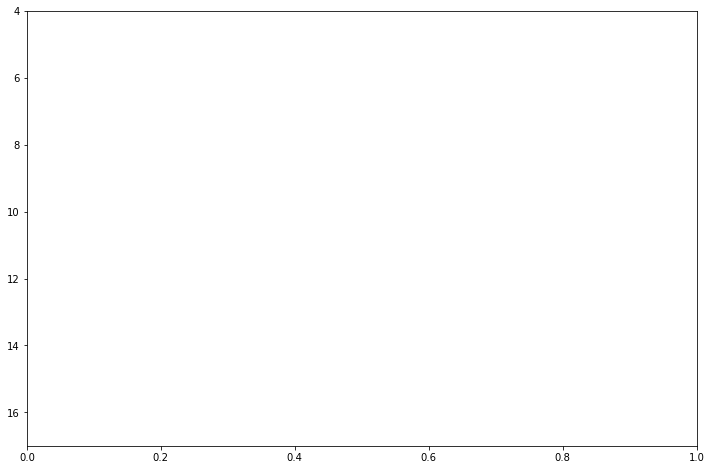

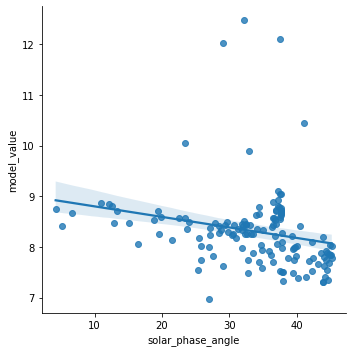

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lmplot(x="solar_phase_angle", y="model_value", data=data_plot)
ax.set_ylim(17, 4)
plt.show()

AttributeError: 'PathCollection' object has no property 'col'

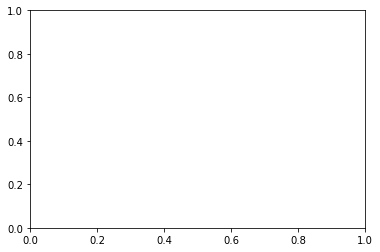

In [22]:
sns.scatterplot(data=data_plot, x="mag_observation", col="e_mag_model", row="", hue="e_mag_model",
                binwidth=2, height=1)

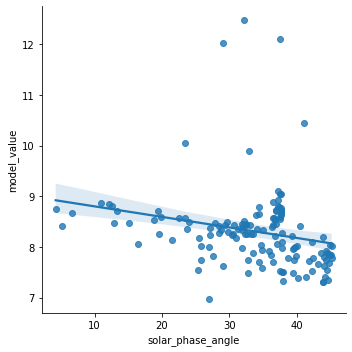

In [28]:
sns.lmplot(x="solar_phase_angle", y="model_value", data=data_plot)